
# Аннотация к решению: 
Используется метод Монте Карло для генерации выборки случайной величины суммы выигрыша. 

**Описание алгоритма:**
Генерируется 5 случайных величин - номера элементов положений середин барабанов. На основе этих чисел формируется матрица с результатами игры. По матрице вычисляется выигрыш и доступные спины. Алгоритм повторяется и выигрыш суммируется до тех пор, пока есть доступные спины. Так как положения каждого из барабанов равновероятны, то используется генератор случайной величины с равномерной функцией распределения.


Доверительные интервалы для дисперсии и мат ожидания вычисляются по формулам [[Ссылка]](https://mse.msu.ru/wp-content/uploads/2020/03/%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F-5-%D0%B4%D0%BE%D0%B2%D0%B5%D1%80%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%B8%D0%BD%D1%82%D0%B5%D1%80%D0%B2%D0%B0%D0%BB%D1%8B.pdf) в предположении что генеральная совокупность имеет нормальную форму.

**Результат:**
В результате реализации, проведены симуляции 10^4, 10^5, 10^6 игр. 
Проведен расчет мат ожидания, дисперсии и доверительные интервалов этих величин. Приведен график распределения игр с ненулевым выигрышем.



------------------------------------------------------------------------------------------


In [32]:
#Remove warnings
import warnings
warnings.simplefilter("ignore")
#Basic data analysis libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import math
import random

array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)

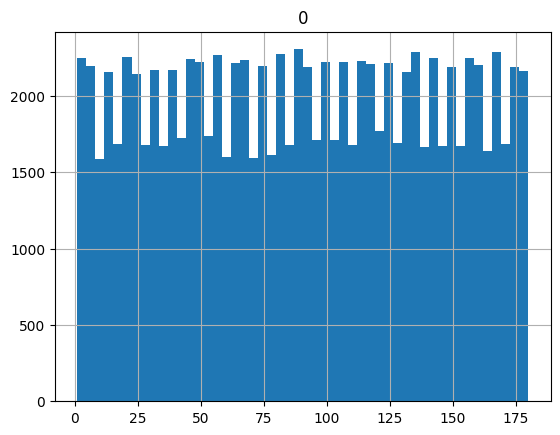

In [33]:
# Визуально проверим "равномерность" генератора
N_Games = 100000
tmp = []

for i in range(1, N_Games):
    tmp.append(random.randint(1, 180))
    
df = pd.DataFrame(tmp)
df.hist(bins=50)

In [7]:
#Параметры барабанов

#Лента центральных барабанов 
BarabanStringCenter = 'GSEDGDBWGFEAHGBCHCBFACGGEFSCAWAHEFDWCGEEGFFGHDCHGBGCHCBHDDDBFHSWHSADCHABCDSEHBDADAEFDHGCEHDSFCAAFCHCBAFDGEFDGBECBSFECWSFWFEBHCDHGGGSGBHGFAHAAAFCFHBADAWDBWEBAEAEBFCWBDWCBFHESDEEBEAG'
#Лента барабанов на краях
BarabanStringBoundary = BarabanStringCenter.replace('W', '')

# Получение матрицы 5х3 результата игры
def GameMatrixResult(S1, S2, S3, S4, S5): 
    # Подставляем входные параметры в положения массивов BarabanStringCenter и BarabanStringBoundary
    arr = [[BarabanStringCenter[S1-1], BarabanStringCenter[S2-1], BarabanStringCenter[S3-1], BarabanStringCenter[S4-1], BarabanStringCenter[S5-1]], 
           [BarabanStringCenter[S1], BarabanStringCenter[S2], BarabanStringCenter[S3], BarabanStringCenter[S4], BarabanStringCenter[S5]], 
           [BarabanStringCenter[S1+1], BarabanStringCenter[S2+1], BarabanStringCenter[S3+1], BarabanStringCenter[S4+1], BarabanStringCenter[S5+1]]]
    arr = np.array(arr)
    return(arr)

N_BarabanStringCenter = len(BarabanStringCenter)-1
N_BarabanStringBoundary = len(BarabanStringBoundary)-1

tmp = GameMatrixResult(1, 2, 1, 1, 1)

print('Пример одной реализации игры \n' + str(tmp))

Пример одной реализации игры 
[['G' 'S' 'G' 'G' 'G']
 ['S' 'E' 'S' 'S' 'S']
 ['E' 'D' 'E' 'E' 'E']]


In [13]:
add_spin3 = 5
add_spin4 = 10
add_spin5 = 15

def PrizeResult(MatrixResult):
    PrizeValue = 0
    add_spin = 0

    # По таблице выплат считаем выигрыш по всем линиям выплат
    # 9 линий выплат
    lines = []

    lines.append(MatrixResult[0, 0]+MatrixResult[0, 1]+MatrixResult[0, 2]+MatrixResult[0, 3]+MatrixResult[0, 4])
    lines.append(MatrixResult[1, 0]+MatrixResult[1, 1]+MatrixResult[1, 2]+MatrixResult[1, 3]+MatrixResult[1, 4])
    lines.append(MatrixResult[2, 0]+MatrixResult[2, 1]+MatrixResult[2, 2]+MatrixResult[2, 3]+MatrixResult[2, 4])

    lines.append(MatrixResult[0, 0]+MatrixResult[1, 1]+MatrixResult[2, 2]+MatrixResult[1, 3]+MatrixResult[0, 4])
    lines.append(MatrixResult[2, 0]+MatrixResult[1, 1]+MatrixResult[0, 2]+MatrixResult[1, 3]+MatrixResult[2, 4])
    lines.append(MatrixResult[0, 0]+MatrixResult[1, 1]+MatrixResult[1, 2]+MatrixResult[1, 3]+MatrixResult[0, 4])

    lines.append(MatrixResult[2, 0]+MatrixResult[1, 1]+MatrixResult[1, 2]+MatrixResult[1, 3]+MatrixResult[2, 4])
    lines.append(MatrixResult[0, 0]+MatrixResult[0, 1]+MatrixResult[1, 2]+MatrixResult[2, 3]+MatrixResult[2, 4])
    lines.append(MatrixResult[2, 0]+MatrixResult[2, 1]+MatrixResult[1, 2]+MatrixResult[0, 3]+MatrixResult[0, 4])

    d = {'AAA': 4, 'AAAA': 20, 'AAAAA': 40, 
         'BBB': 3, 'BBBB': 15, 'BBBBB': 30,
        'CCC': 2, 'CCCC': 10, 'CCCCC': 20,
        'DDD': 1, 'DDDD': 5, 'DDDDD': 10,
        'EEE': 0.4, 'EEEE': 2, 'EEEEE': 4,
        'FFF': 0.3, 'FFFF': 1.5, 'FFFFF': 3,
        'GGG': 0.2, 'GGGG': 1, 'GGGGG': 2,
        'HHH': 0.1, 'HHHH': 0.5, 'HHHHH': 1}

    #ищем шаблоны по ключам словаря
    for i in lines: 
        for j in list(d.keys()):   
            if i.find(j)!=-1:
                PrizeValue = PrizeValue + d[j]
       
    # В зависимости от числа элементов S в матрице выберем число спинов
    # 3 символа – 5 фри-спинов, 4 символа – 10 фри-спинов, 5 символов – 15 фри-спинов  
    num_of_S = len(np.where(MatrixResult=='S')[0])
    if num_of_S == 3:
        add_spin = 5
    if num_of_S == 4:
        add_spin = 10
    if num_of_S == 5:
        add_spin = 15        
    
    return PrizeValue, add_spin


print('Пример расчета размера приза по всем 9 линиям выплат и числа фриспинов за 1 вращение \n' )
print('Матрица игры \n' + str(tmp))      
print('Сумма выигрыша \n' + str(PrizeResult(tmp)[0])) 
print('Число начисленных фриспинов за раунд \n' + str(PrizeResult(tmp)[1])) 

#      + str(PrizeResult(tmp)[0]))

Пример расчета размера приза по всем 9 линиям выплат и числа фриспинов за 1 вращение 

Матрица игры 
[['G' 'S' 'G' 'G' 'G']
 ['S' 'E' 'S' 'S' 'S']
 ['E' 'D' 'E' 'E' 'E']]
Сумма выигрыша 
0.6000000000000001
Число начисленных фриспинов за раунд 
15


In [54]:
from scipy import stats
# Блок симуляции игры (Game Simulation - название функции)
N_Games = [10000, 100000, 1000000]
X = []

for m in N_Games:
    for i in range(1, m):
        available_num_spin = 1
        PrizeValuePerGame = 0
        # Пока число доступных прокруток >1
        k = 0 #счетчик игр
        while available_num_spin > 0:
            # Генерируется 5 случайных чисел: 3 от 1 до N_BarabanStringCenter, 2 от 1 до N_BarabanStringBoundary
            Baraban_1 = random.randint(1, N_BarabanStringBoundary-1)
            Baraban_2 = random.randint(1, N_BarabanStringCenter-1)
            Baraban_3 = random.randint(1, N_BarabanStringCenter-1)
            Baraban_4 = random.randint(1, N_BarabanStringCenter-1)
            Baraban_5 = random.randint(1, N_BarabanStringBoundary-1)

            MatrixOfGame = GameMatrixResult(Baraban_1, Baraban_2, Baraban_3, Baraban_4, Baraban_5)
            PrizeValuePerSpin, add_spin = PrizeResult(MatrixOfGame)        
            available_num_spin = available_num_spin - 1 + add_spin
            PrizeValuePerGame = PrizeValuePerGame + PrizeValuePerSpin
            k = k + 1
        #print('Игра номер '+str(i) + ' Выигрыш ' + str(PrizeValuePerGame) + ' Число оборотов ' + str(k))
        X.append(PrizeValuePerGame)
        
        
    df = pd.DataFrame(X, columns =['Выигрыш за 1 игру'])
  
    alpha = 0.05                       # significance level = 5%
    t = stats.t.ppf(1 - alpha/2, m-1)   # t-critical value for 95% CI = 2.093
    
    tmp = df['Выигрыш за 1 игру'].mean()*t/math.sqrt(m)
    leftmean_confidence_interval = df['Выигрыш за 1 игру'].mean()-tmp
    rightmean_confidence_interval = df['Выигрыш за 1 игру'].mean()+tmp
    #0.9, 0.95, 0.99
    


    alpha = 0.05               # significance level = 5%
    s2 = df['Выигрыш за 1 игру'].var()   # sample variance
    leftvar_confidence_interval = (m - 1) * s2 / stats.chi2.ppf(alpha / 2, m - 1)
    rightvar_confidence_interval = (m - 1) * s2 / stats.chi2.ppf(1 - alpha / 2, m - 1)

     
    print('Число генерируемых игр N='+str(m))
    print('Выборочное среднее ' + str(df['Выигрыш за 1 игру'].mean()))
    print('Левая граница 95%  доверительного интервала среднего ' + str(leftmean_confidence_interval))
    print('Правая граница 95% доверительного интервала  среднего ' + str(rightmean_confidence_interval)) 
    
    print('Выборочная дисперсия ' + str(df['Выигрыш за 1 игру'].var()))
    print('Левая граница 95% доверительного интервала дисперсии ' + str(leftvar_confidence_interval))
    print('Правая граница 95% доверительного интервала дисперсии ' + str(rightvar_confidence_interval)) 

    #print('Медиана ' + str(df['Выигрыш за 1 игру'].median()))
        
  

Число генерируемых игр N=10000
Выборочное среднее 0.6864186418641894
Левая граница 95%  доверительного интервала среднего 0.672963454972635
Правая граница 95% доверительного интервала  среднего 0.6998738287557439
Выборочная дисперсия 9.402688102778141
Левая граница 95% доверительного интервала дисперсии 9.668867472695885
Правая граница 95% доверительного интервала дисперсии 9.14739863357046
Число генерируемых игр N=100000
Выборочное среднее 0.6677221404025718
Левая граница 95%  доверительного интервала среднего 0.663583581654614
Правая граница 95% доверительного интервала  среднего 0.6718606991505297
Выборочная дисперсия 9.145672404316699
Левая граница 95% доверительного интервала дисперсии 9.226369094406357
Правая граница 95% доверительного интервала дисперсии 9.06603456998951
Число генерируемых игр N=1000000
Выборочное среднее 0.6642426961514107
Левая граница 95%  доверительного интервала среднего 0.6629408028141929
Правая граница 95% доверительного интервала  среднего 0.665544589488

Таким образом мат. ожидание ≈ 0.66, дисперсия ≈ 8.83

<AxesSubplot: >

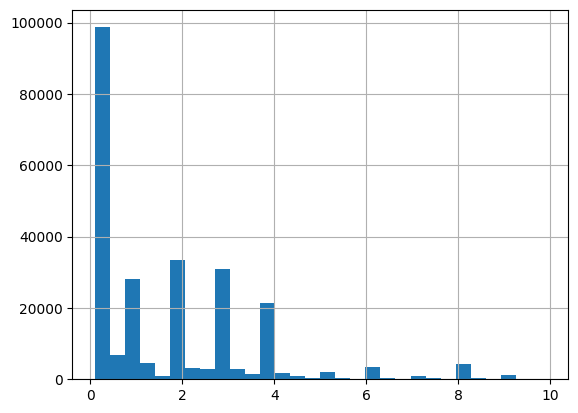

In [64]:
#распределение ненулевых выигрышей
df_tmp = df['Выигрыш за 1 игру'][df['Выигрыш за 1 игру']>0.01]
display(df_tmp[df['Выигрыш за 1 игру']<10].hist(bins=30))  